In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [7]:
codes = ['BG','FG']

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),ShiftScaleRotate(),OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

1. Images/1. Training Set/mmac_task_2_train_CNV_0005.png


<Axes: >

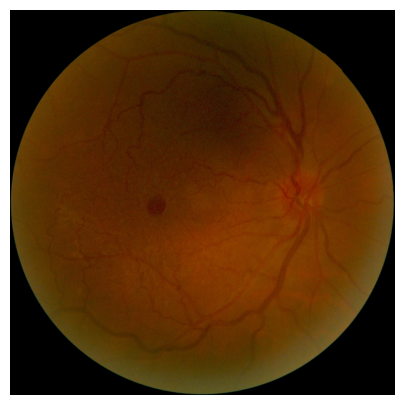

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

2. Groundtruths/1. Training Set/mmac_task_2_train_CNV_0005.png


<Axes: >

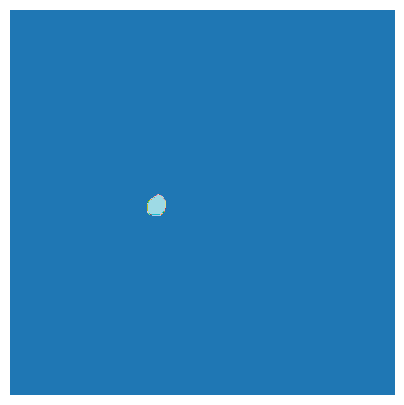

In [15]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [16]:
bs = 4

In [17]:
codes

['BG', 'FG']

In [18]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

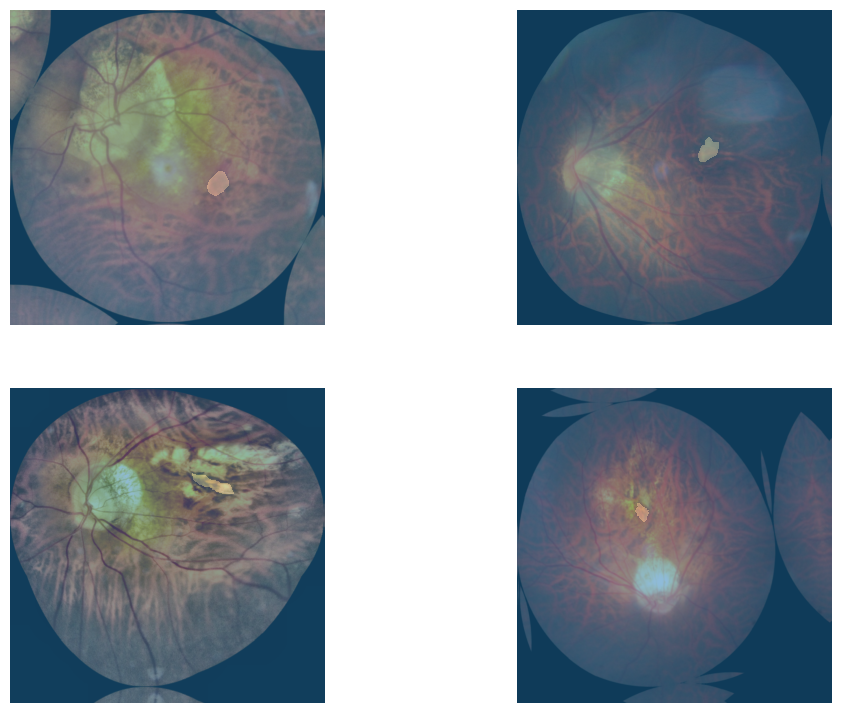

In [19]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
model = smp.DeepLabV3Plus(
    encoder_name="tu-efficientnetv2_rw_m",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [21]:
learn = Learner(dlsTrain,model,metrics=[DiceMulti(),Dice()],loss_func=FocalLossFlat(axis=1),opt_func=ranger).to_fp16()

In [22]:
learn.load('deeplab-tu-efficientnetv2_rw_m_2')

/home/joheras/.conda/envs/python38/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,dice_multi,dice,time
0,0.013669,0.012979,0.499606,0.001923,00:07
1,0.012111,0.010502,0.499805,0.002513,00:05
2,0.009741,0.006597,0.506720,0.017166,00:05
3,0.008067,0.004233,0.538476,0.080348,00:05
4,0.006796,0.003196,0.581296,0.165281,00:05
5,0.005879,0.002848,0.612278,0.227078,00:05
6,0.005158,0.002516,0.623268,0.248747,00:05
7,0.004500,0.002254,0.625769,0.253428,00:05
8,0.003981,0.002175,0.631163,0.264222,00:05
9,0.003592,0.002119,0.654972,0.311861,00:05


Better model found at epoch 0 with dice_multi value: 0.49960608217645136.


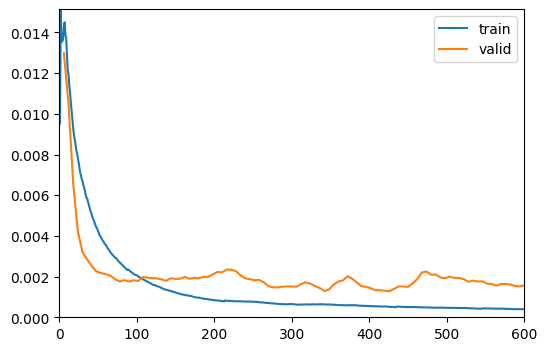

Better model found at epoch 1 with dice_multi value: 0.4998050384545991.
Better model found at epoch 2 with dice_multi value: 0.5067199588758129.
Better model found at epoch 3 with dice_multi value: 0.5384763649660443.
Better model found at epoch 4 with dice_multi value: 0.5812961201178029.
Better model found at epoch 5 with dice_multi value: 0.6122775793471997.
Better model found at epoch 6 with dice_multi value: 0.6232677300647811.
Better model found at epoch 7 with dice_multi value: 0.6257688682608061.
Better model found at epoch 8 with dice_multi value: 0.631162760324073.
Better model found at epoch 9 with dice_multi value: 0.6549723537816605.
Better model found at epoch 10 with dice_multi value: 0.6677335404566743.
Better model found at epoch 11 with dice_multi value: 0.6709802074481266.
Better model found at epoch 12 with dice_multi value: 0.7014757949451813.
Better model found at epoch 13 with dice_multi value: 0.7112696664169503.
Better model found at epoch 15 with dice_multi v

In [23]:
fname="deeplab-tu-efficientnetv2_rw_m"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_flat_cos(100, 1e-3,cbs=callbacksFitBeforeUnfreeze)

In [24]:
# learn1 = Learner(dlsTrain,model)

In [25]:
# learn1.load('deeplab-resnet50')

In [27]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'deeplab-efficientnet-choroidal-2.pth')